In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()
from results import load

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

# Reading the results

In [10]:
#config
experiment_name = "full"
load_raw = True
all = None
providers = None
num_repetitions = None
configs = None

if load_raw:

    providers = ["aws","azure","ibm","gcf"] 
    num_repetitions = 1
    configs = ["0,0,1", "0,0,2","0,0,0.5","60,60,1","60,60,0.5"]


    all = load(experiment_name, providers,configs,num_repetitions,True)
    all.to_csv("results/full.csv")
else :
    all = pd.read_csv("results/full.csv")#
    providers = all["Provider"].unique()
    num_repetitions = all["run"].max()
    configs = all["WL"].unique()

all.columns


b'Skipping line 4058: expected 15 fields, saw 20\n'


Index(['RId', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat', 'RFailed',
       'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat', 'TLat',
       'COs', 'RInput', 'Provider', 'RLat', 'BLat', 'RResult', 'run',
       'sourceFile', 'RCode', 'RSuccessed', 'HId'],
      dtype='object')

In [11]:
def plotWorkload(ax,data,label="Target Workload",interval=1000):
    data["RStart_1s"] = round(data["RStart"]/interval)
    lats = data.groupby(["RStart_1s"])['RId'].count().reset_index(name="workload")
    sns.lineplot(x="RStart_1s", y='workload', data=lats, color="gray",label=label,ax=ax)    

In [12]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":palette[0]
    },
    "ibm":{
        "name":"ICF",
        "color":palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":palette[5]
    },
}


In [13]:
all = all[(all["Phase"] != "none")]

### Cost per Request

In [25]:
def costPerSecond(ax,all,provider,workload):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    #plot
    sns.violinplot(x='Phase', y='ECost', data=data,  inner='quartile')
    #ax.scatter(x="EStart_1s",y="ECost",data=data,label=provider,color=style[provider]["color"],alpha=0.8)


    # ax.set_xlim([0,300])
    ax.set_xlabel("Phases")
    ax.set_ylabel(r"cost [$\mu$\$]")
    ax.set_ylim([0,1000])
    ax.grid(False)
    #title
    ax.set_title("{} - Cost per Request".format(style[provider]["name"]))
#     data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
#     data = data.copy()
    
#     #goup by second
#     data["EStart_1s"] = round(data["EStart"]/1000)
#     #sum up cost
#     data = data.groupby(["EStart_1s","Phase"])["ECost"].sum().reset_index(name="ECost")
#     #plot
    
#     ax.scatter(x="EStart_1s",y="ECost",data=data,label=provider,color=style[provider]["color"],alpha=0.8)
   
    
#     ax.set_xlim([0,300])
#     ax.set_xlabel("time [s]")
#     ax.set_ylabel(r"cost [$\mu$\$]")
    
#     #highlight phases
#     ax.axvline(60,alpha=0.5)
#     ax.axvline(120,alpha=0.5)
#     ax.grid(False)
#     ax.set_xticks(ticks=[30,90,210])
#     ax.set_xticks(ticks=range(0,300,20),minor=True)
#     ax.set_xticklabels(["p0","p1","p2"])
#     ax.set_xticklabels(range(0,300,20),minor=True)
#     ax.tick_params(axis='both', which='major', pad=15)
#     #title
#     ax.set_title("{} - Cost per Second".format(style[provider]["name"]))
    
#     #legend
#     ax.legend()

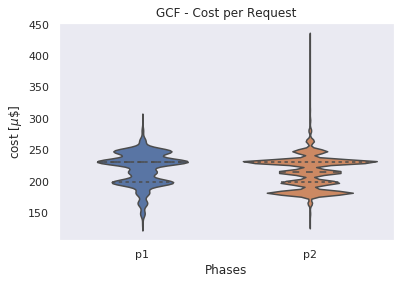

In [15]:

fig,ax = plt.subplots()
costPerSecond(ax,all,"gcf","0,0,2")




## Failed Request

In [30]:
def plotFailedRequestPerSecond(ax,all,provider,workload,plot_target=True,label=None):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    if plot_target:
        plotWorkload(ax,data)
        
    data["RStart_1s"] = round(data["RStart"]/1000)
    #sum up cost
    data = data.groupby(["RStart_1s"])["RFailed"].sum().reset_index(name="RFailed")
    if label == None:
        label = "{}".format(style[provider]["name"])
    
    data = data[data["RFailed"] > 0]
    ax.scatter(x="RStart_1s", marker="+",y='RFailed', data=data, color="indianred",label=label,s=40)
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"failed requests [#]")

    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.2,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,300,20),minor=True)
    ax.set_xticklabels(["p0","p1","p2"])
    ax.set_xticklabels(range(0,300,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)

    #title
    ax.set_title("{} - Failed Request per Second".format(style[provider]["name"]))

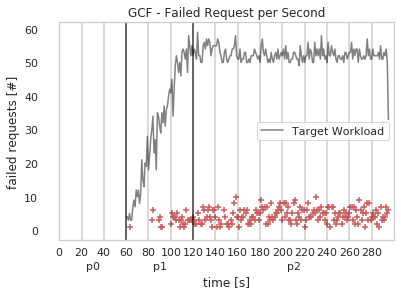

In [31]:
fig,ax = plt.subplots()
plotFailedRequestPerSecond(ax,all,"gcf","0,0,1")

### Throughput

In [18]:
def thruputPerSecond(ax,all,provider,workload,filter_failed=False,with_failed=True):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    
    if with_failed:
        plotFailedRequestPerSecond(ax,data,provider,workload,False,"{} Failed Requests".format(style[provider]["name"]))
    
    if filter_failed:
        data = data[data["RFailed"] == False]
        
    
    #goup by second
    data["REnd_1s"] = round(data["REnd"]/1000)
    plotWorkload(ax,data)
    #sum up cost
    data = data.groupby(["REnd_1s"])["RId"].count().reset_index(name="throughput")
    #plot
    ax.scatter(x="REnd_1s",y="throughput",data=data,label="{} Throughput".format(style[provider]["name"]),c=style[provider]["color"],alpha=0.8,s=8,)
    
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"request [#]")
    ax.set_ylim([0,180])
    
    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.1,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,300,20),minor=True)
    ax.set_xticklabels(["p0","p1","p2"])
    ax.set_xticklabels(range(0,300,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)

    #title
    ax.set_title("{} - Throughput per Second".format(style[provider]["name"]))

    #legend
    ax.legend()


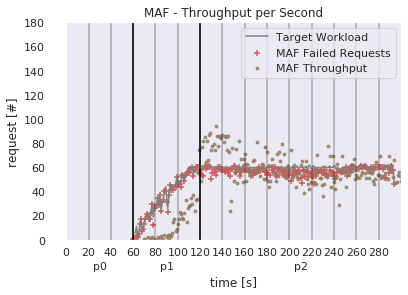

In [19]:
fig,ax = plt.subplots()
thruputPerSecond(ax,all,"azure","0,0,1",False)

## Request Latency

In [20]:
def plotRequestResponseViolin(ax,all,provider,workload):
    ax.set_title("{} Request Response Latency ".format(style[provider]["name"]))
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[data["RLat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    #data = data[data["Phase"].isin(["p1","p2"])]
    inner = None
    sns.violinplot(x='Phase', y='RLat', data=data,  scale='area',cut=0,ax=ax,  inner='quartile')
    
    #ax.set_yscale('log')

    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Request Response Latency [s]")
    ax.set_ylim([0,30])
    #highlight phases

    #ax.set_xticklabels(["p0","p1","p2","none"])

    delta = 0.02
    delta = 0.02

    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

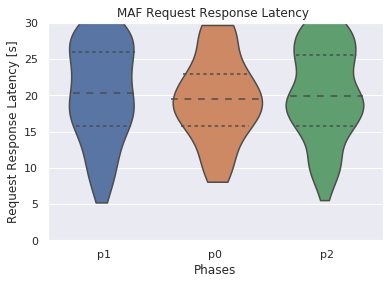

In [21]:
fig,ax = plt.subplots()

plotRequestResponseViolin(ax,all,"azure","60,60,1")

## Eexecution Latancy

In [27]:
def plotExecutionLatencyViolin(ax,all,provider,workload):
    ax.set_title("{} Execution Latency ".format(style[provider]["name"]))
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[data["ELat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    #data = data[data["Phase"].isin(["p1","p2"])]
    inner = None
    sns.violinplot(x='Phase', y='ELat', data=data,  scale='area',cut=0,ax=ax,  inner='quartile')
    
    #ax.set_yscale('log')

    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Execution Latency [s]")
    ax.set_ylim([0,10])
    #highlight phases

    #ax.set_xticklabels(["p0","p1","p2","none"])

    delta = 0.02
    delta = 0.02

    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

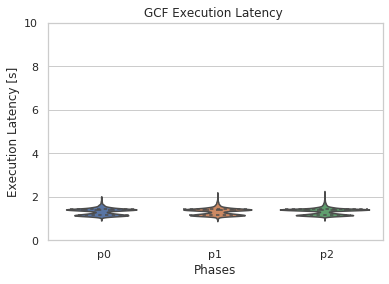

In [28]:
fig,ax = plt.subplots()

plotExecutionLatencyViolin(ax,all,"gcf","60,60,1")

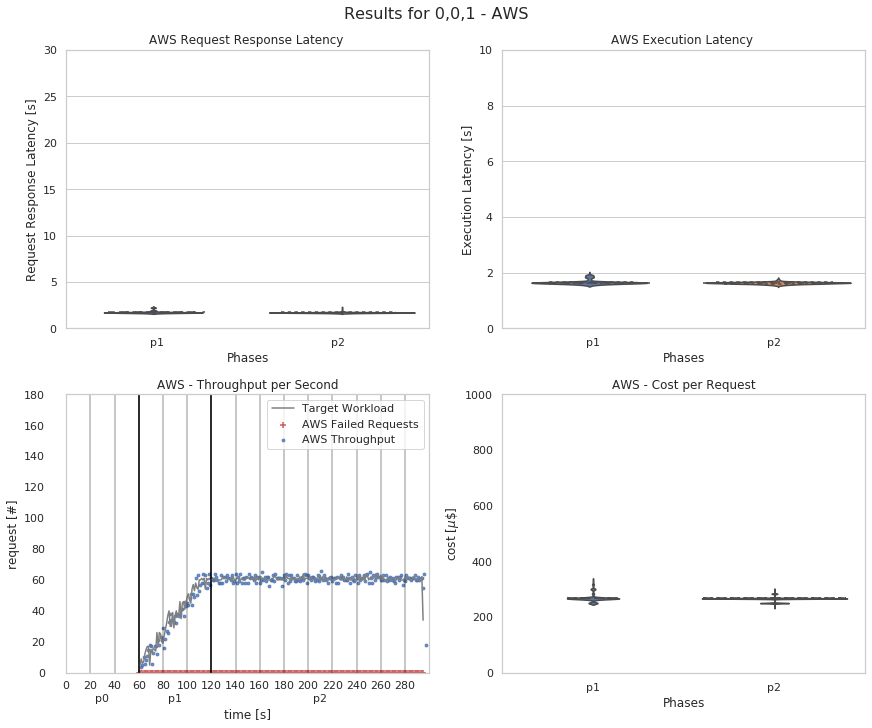

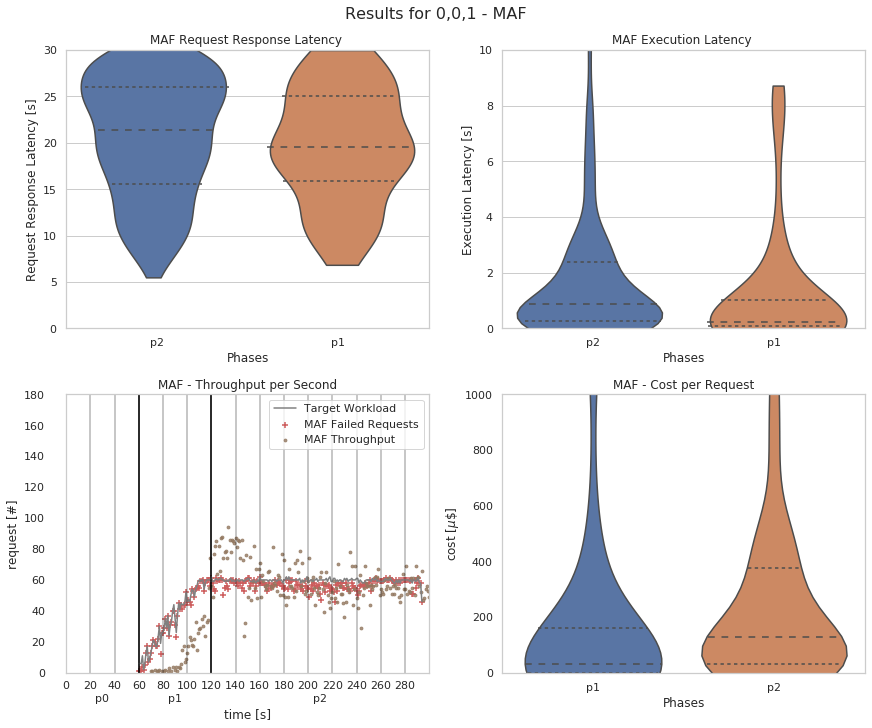

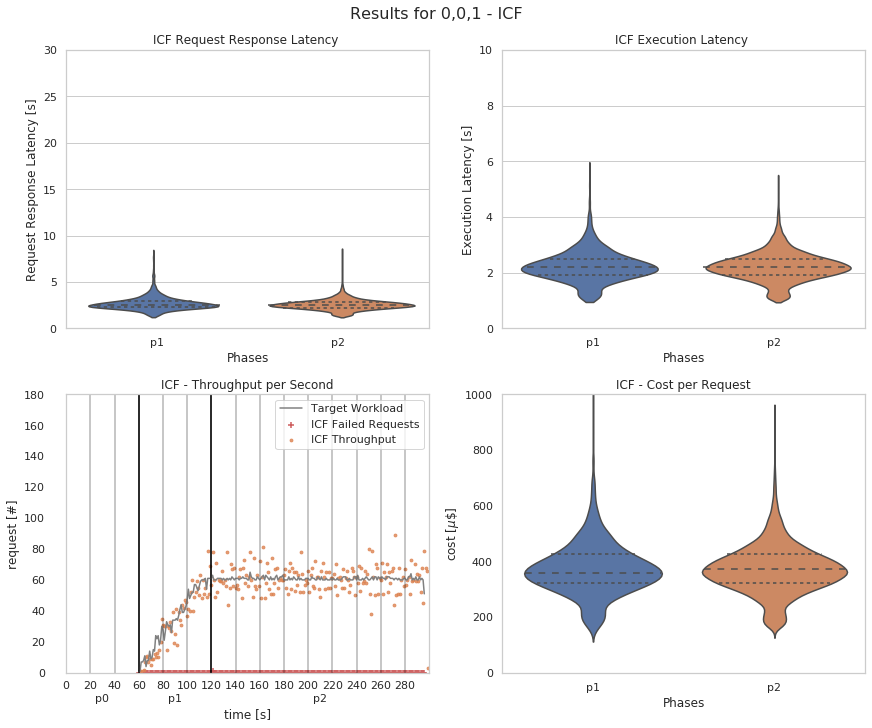

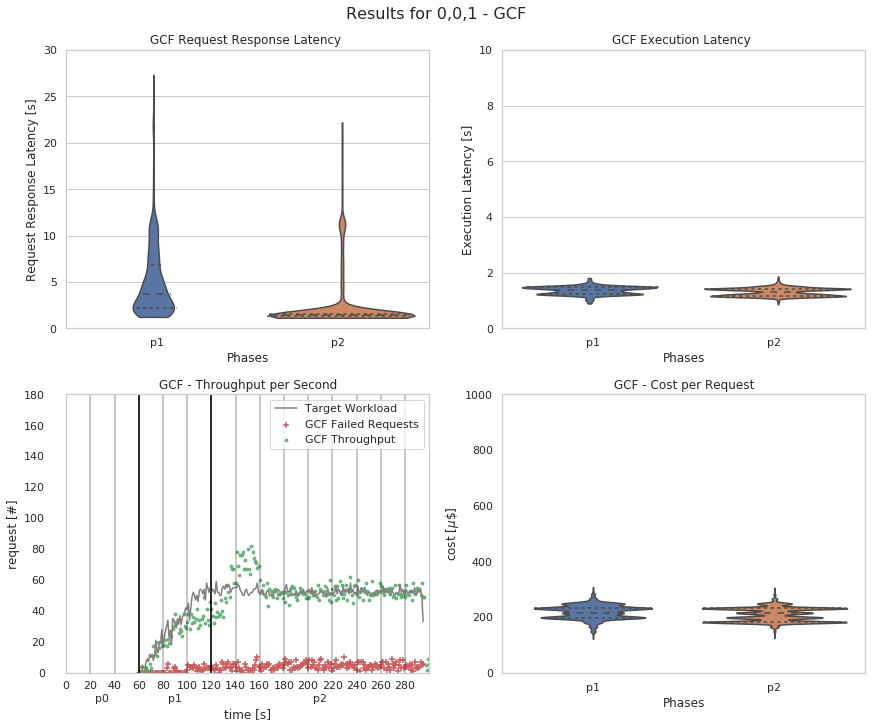

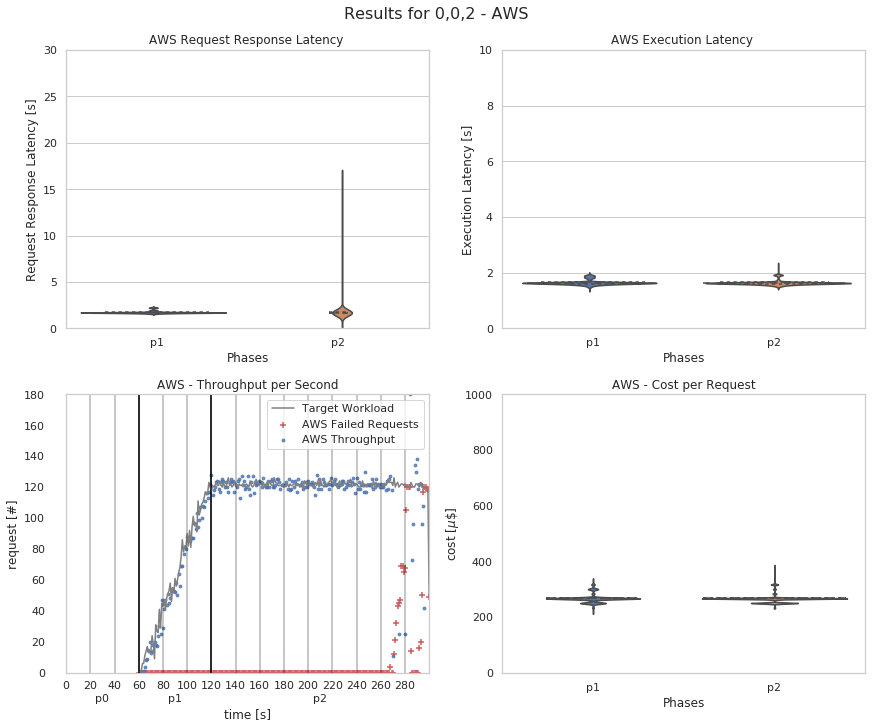

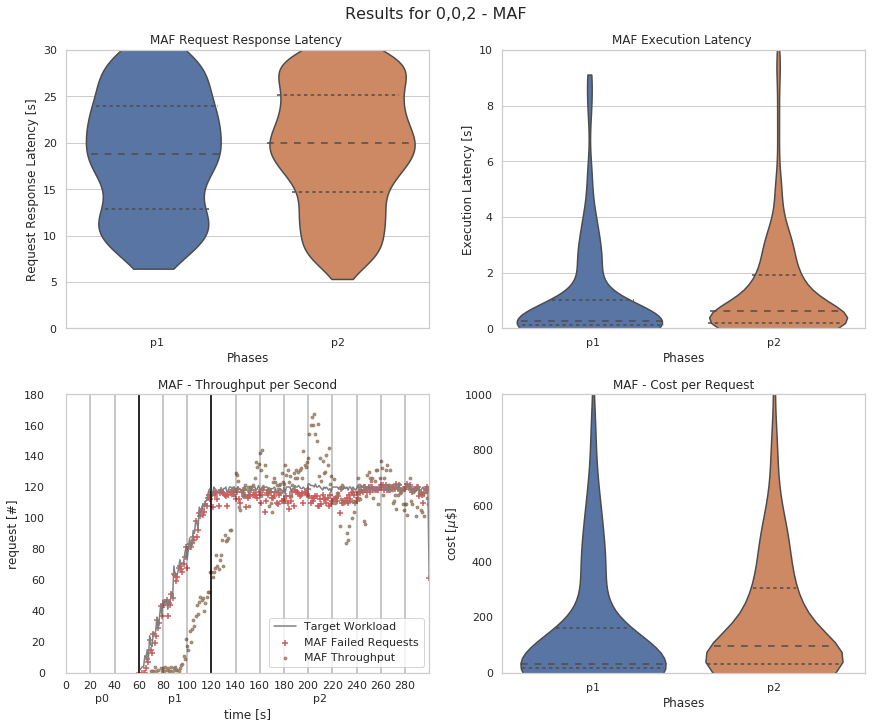

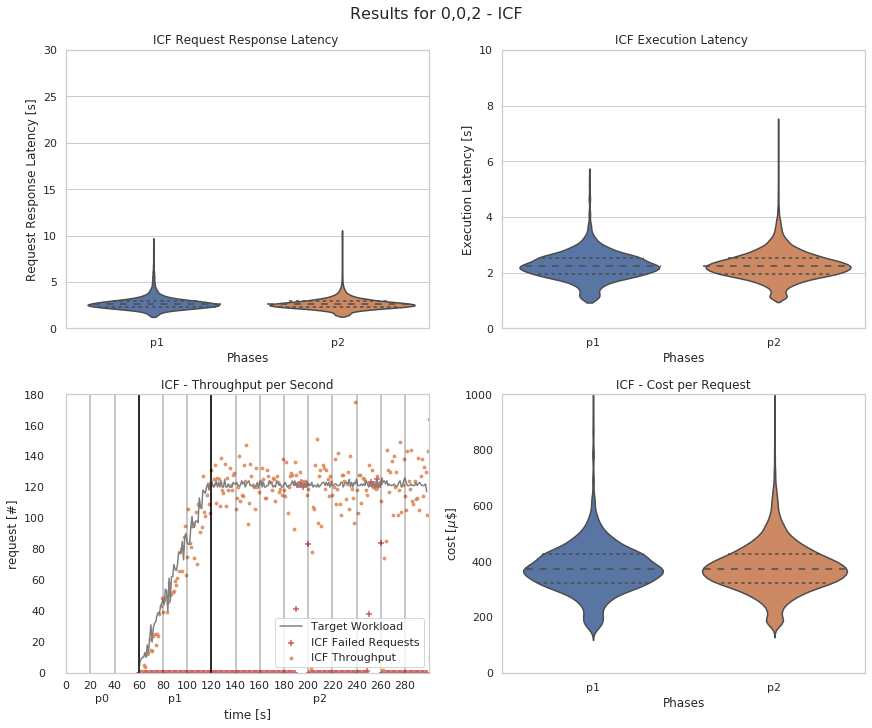

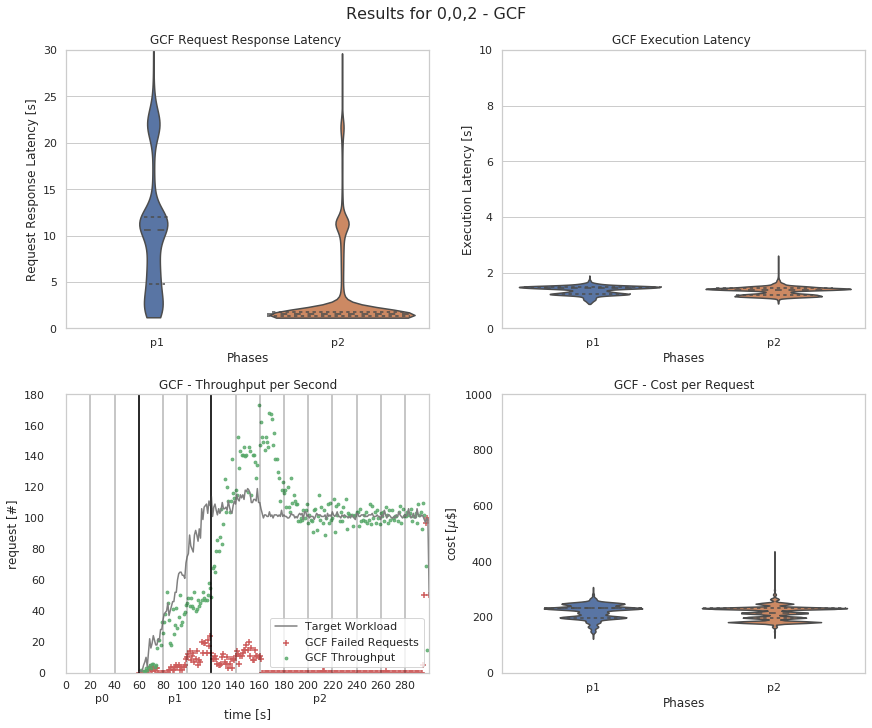

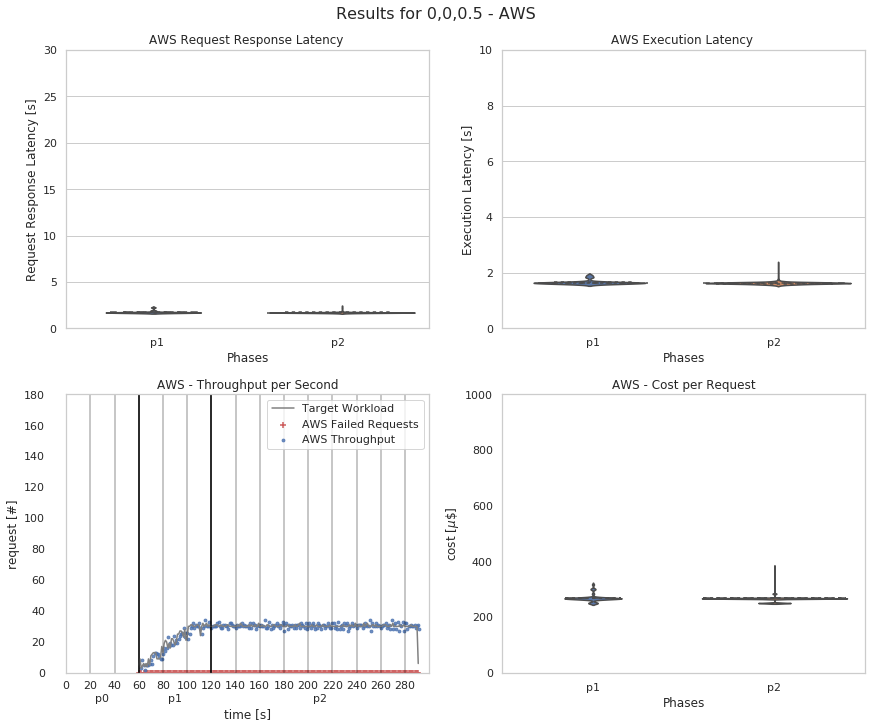

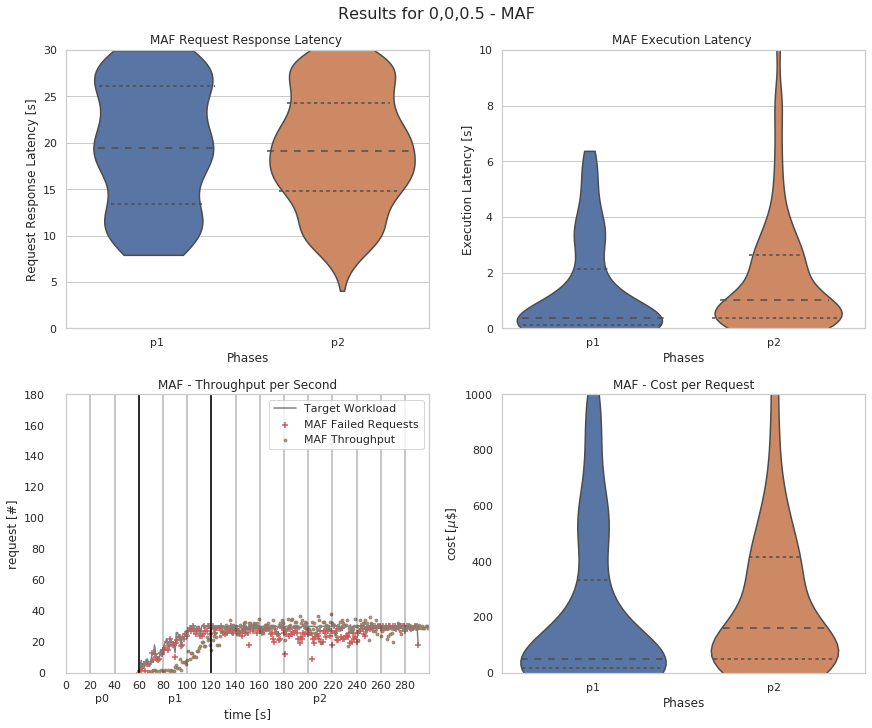

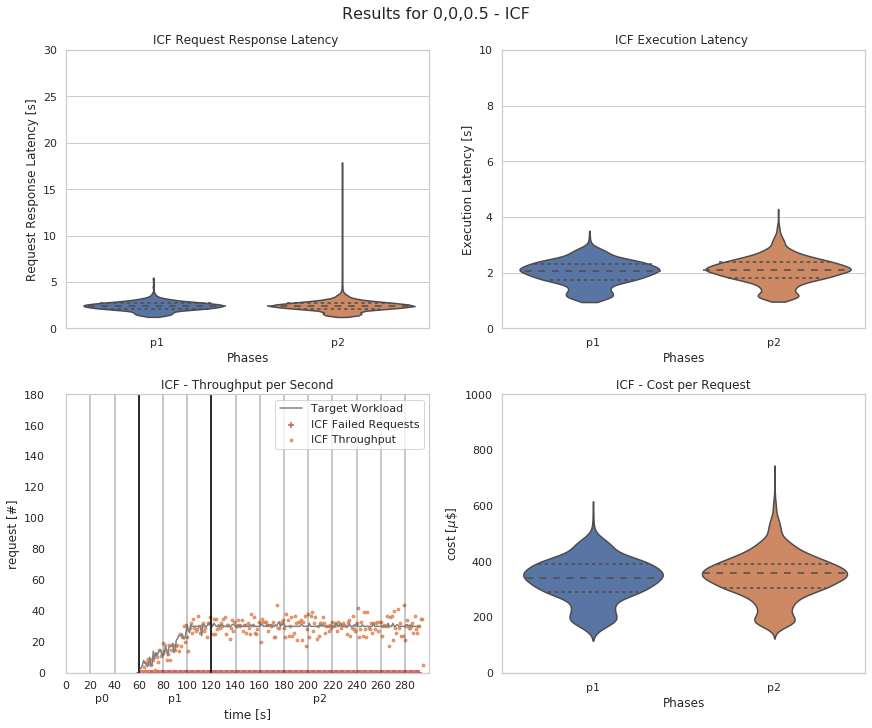

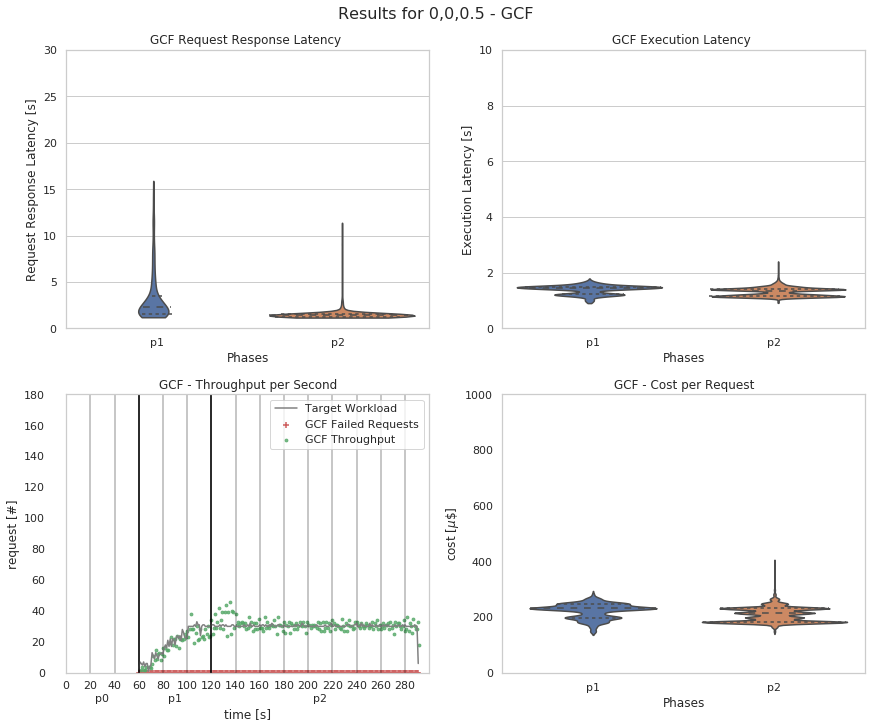

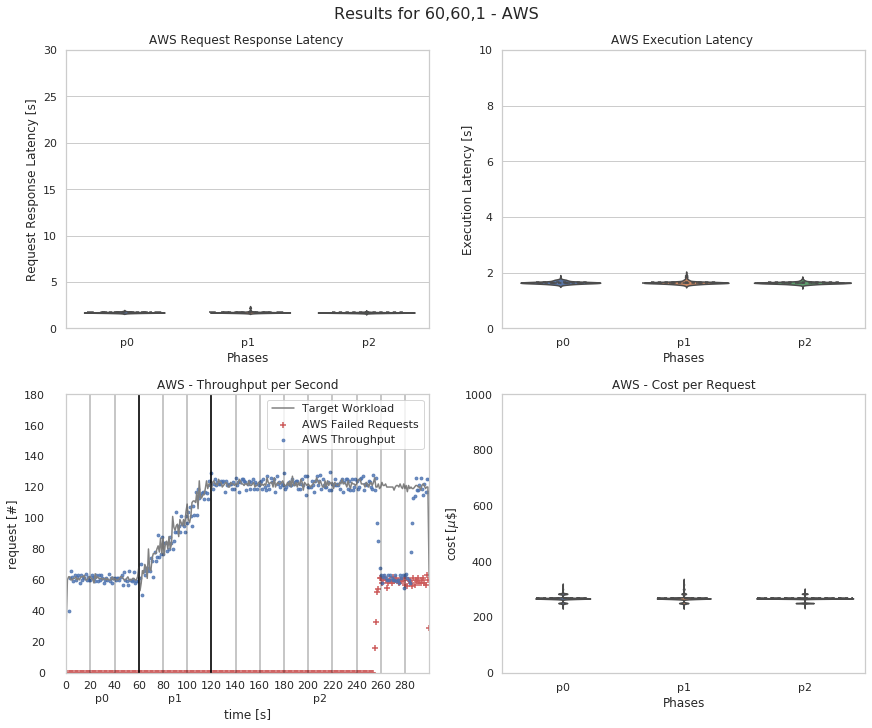

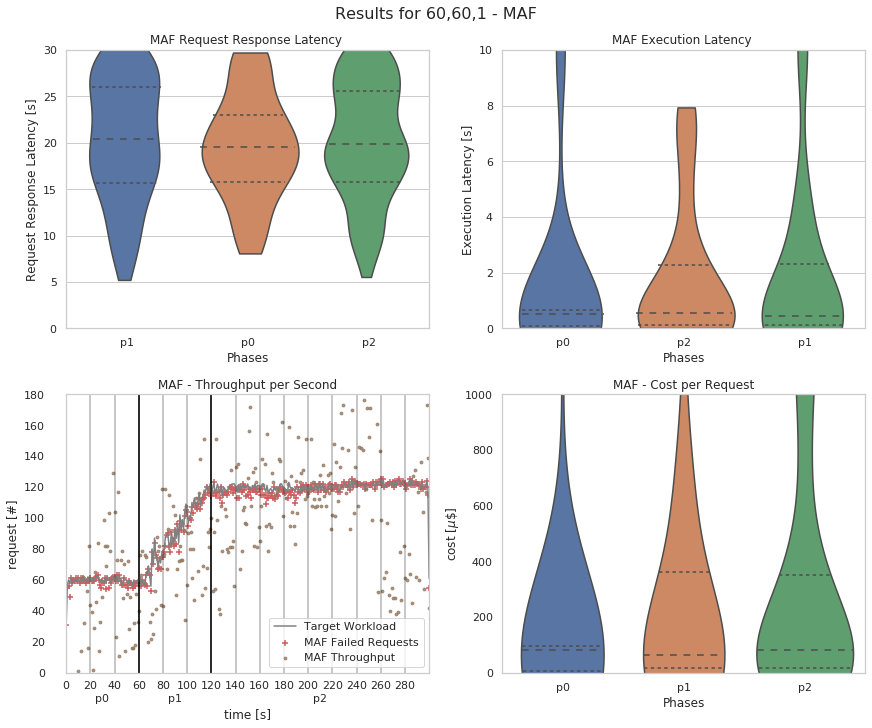

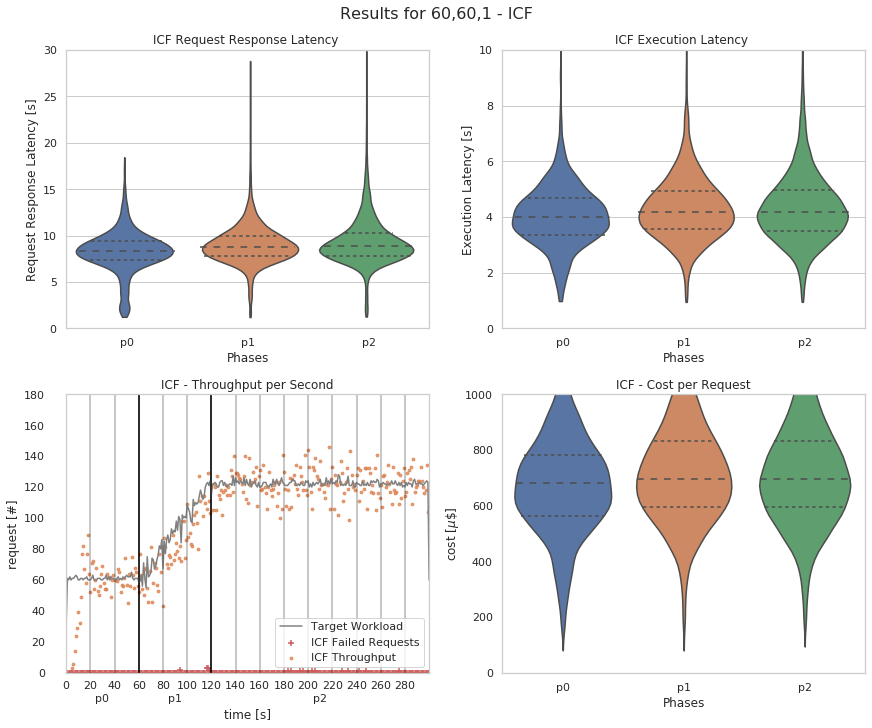

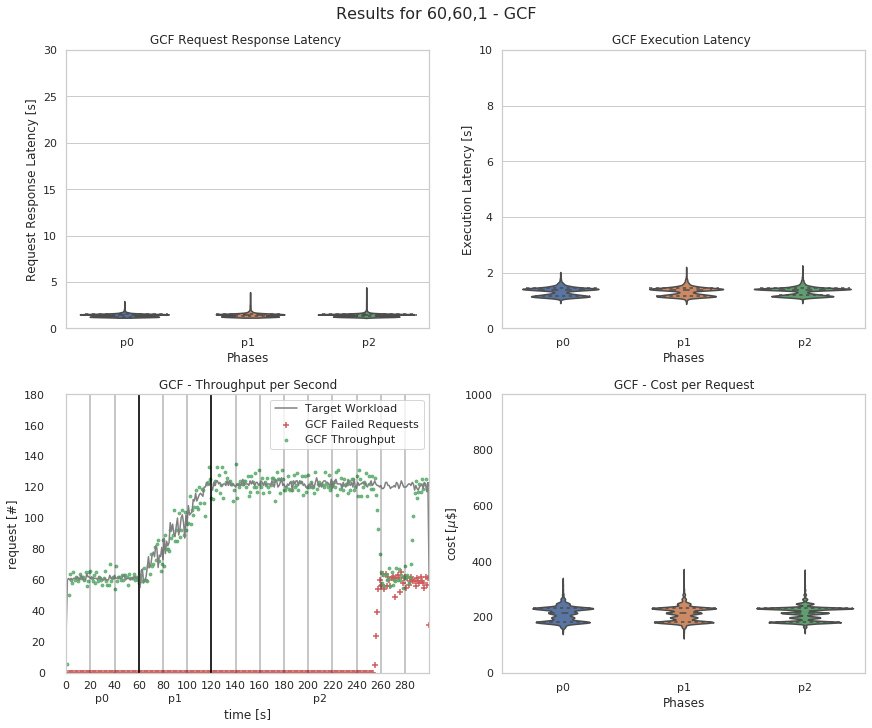

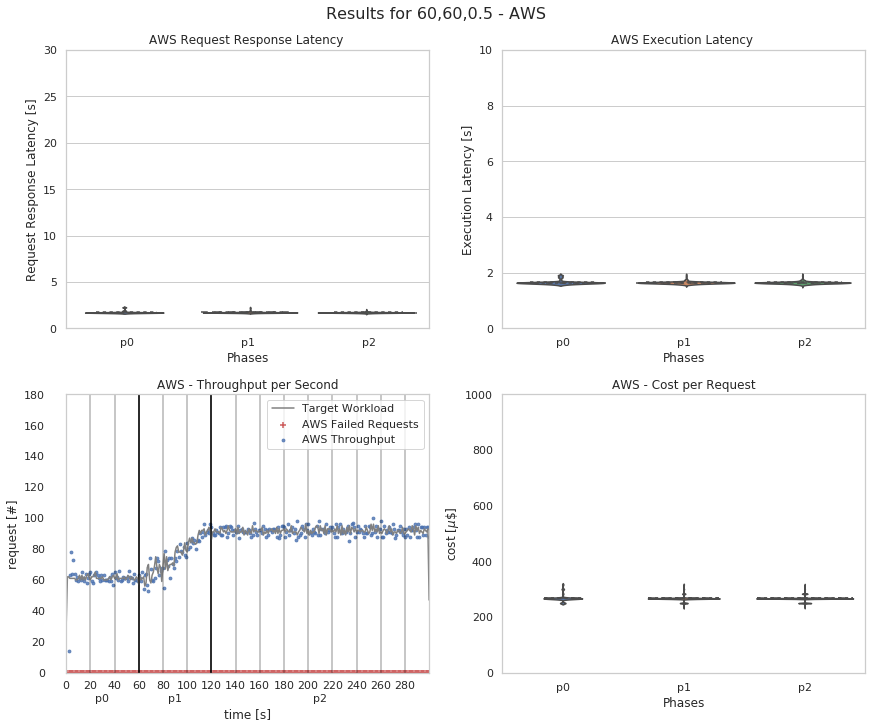

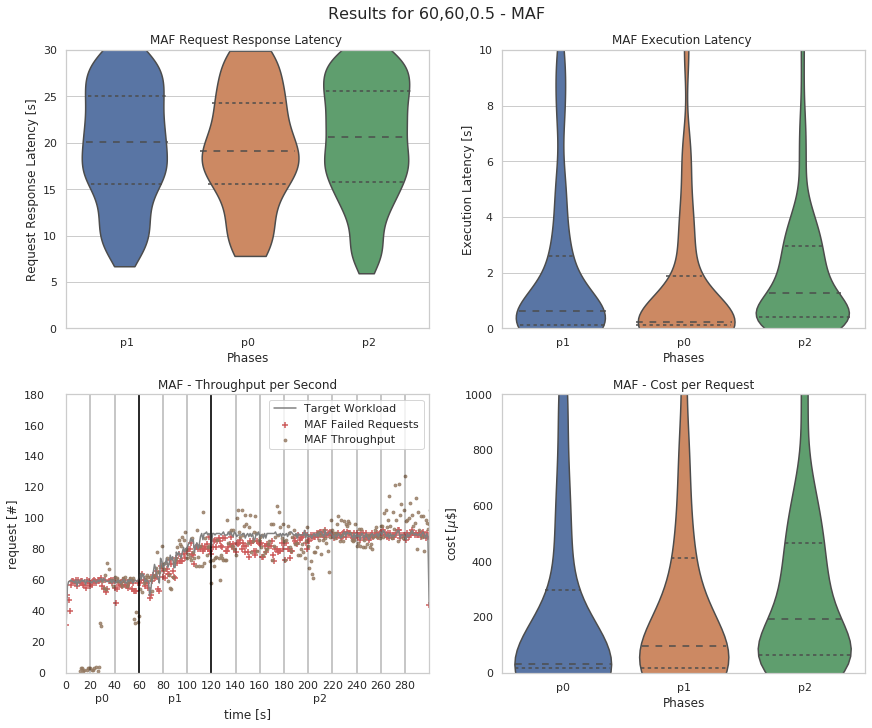

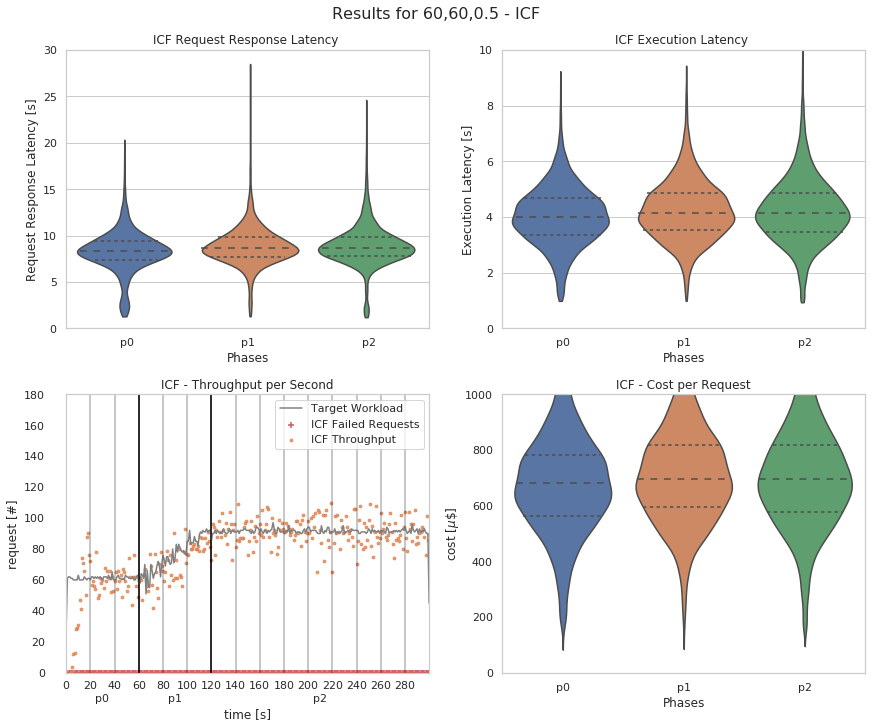

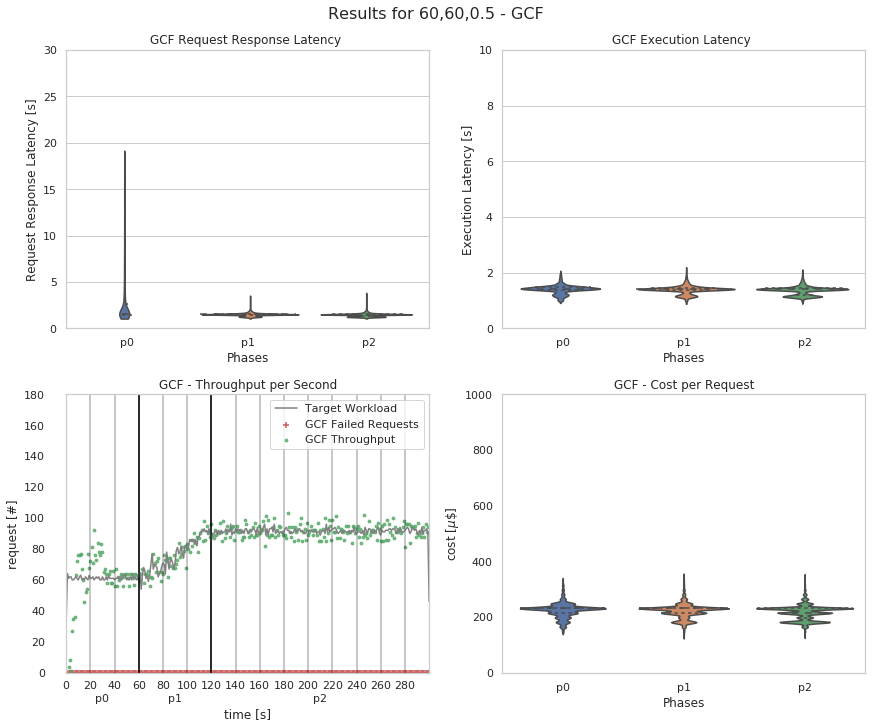

In [29]:
sns.set(style="whitegrid")
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
with PdfPages("reports/overview.pdf") as pdf:
    for workload in configs:
        for provider in providers:
            fig = plt.figure(constrained_layout=True,figsize=(12,10))
            gs = GridSpec(2, 2, figure=fig)
            plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16)
            ax = fig.add_subplot(gs[0, 0])
            plotRequestResponseViolin(ax,all,provider,workload)
            ax = fig.add_subplot(gs[0, 1])
            plotExecutionLatencyViolin(ax,all,provider,workload)
            ax = fig.add_subplot(gs[1, 0])
            thruputPerSecond(ax,all,provider,workload)
            ax = fig.add_subplot(gs[1, 1])
            costPerSecond(ax,all,provider,workload)
            pdf.savefig(fig)


In [ ]:

def plotLatencyBand(ax,data,group,lat,label="Latency",interval=1000):
    g = group+"_"+lat+"_"+str(interval)
    data[g] = round(data[group]/interval)
    lats = data.groupby([g])[lat].agg([np.mean,np.max,np.min]).reset_index()
    sns.lineplot(x=g, y='mean', data=lats,ax=ax,label=label)
    ax.fill_between(x=g,y1="amax",y2="amin",data=lats,alpha=0.5)

    
def plotWorkload(ax,data,time,label="Workload",interval=1000):
    g = time+"_WL_"+str(interval)
    data[g] = round(data[time]/interval)
    lats = data.groupby([g])['RId'].count().reset_index(name="workload")
    sns.lineplot(x=g, y='workload', data=lats, color="gray",label=label,ax=ax2)    



In [ ]:
#prep data
data = all.copy()

data['RStart_1s'] = round(data["RStart"]/1000)
data['REnd_1s'] = round(data["REnd"]/1000)

data = data[data["Phase"].isin(["p0","p1","p2"])]
#preselect
fig,axs = plt.subplots(5,figsize=(16,18), dpi= 80)
idx = 0
for workload in configs:
    ax = axs[idx]
    for provider in providers:
        ax.set_title("delta Thruput {}".format(workload))
        tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
        started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
        started_requests = started_requests["y"].ewm(span=30)
        #started_requests.mean().plot(style = 'tab:red')


        finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
        finished_requests = finished_requests["y"].ewm(span=30)
        delta_thr = (finished_requests.mean()-started_requests.mean())
        if workload[0] == "0":
            delta_thr = np.pad(delta_thr,(60,0),'constant')
        delta_thr = delta_thr[0:300]
        sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax,label=provider)
    ax.axvline(60)
    ax.axvline(120)
    ax.set_ylim([-20,20])
    ax.legend()
    idx+=1

#plt.plot("RStart_1s","y",data=started_requests,color="tab:red")
# tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
# finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")



In [ ]:
fig,ax = plt.subplots()
plt.title("delta Thruput {}".format(workload))
tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
started_requests = started_requests["y"].ewm(span=30)
#started_requests.mean().plot(style = 'tab:red')


finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
finished_requests = finished_requests["y"].ewm(span=30)
delta_thr = (finished_requests.mean()-started_requests.mean())
sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax)

In [ ]:
run = 1
workloads = all['WL'].unique()
providers = all['Provider'].unique()
from matplotlib.gridspec import GridSpec

positions = {"aws":(0,0),"gcf":(1,0),"ibm":(0,1),"azure":(1,1)}

for WL in workloads:
    fig = plt.figure(constrained_layout=True,figsize=(14,10))
    gs = GridSpec(2, 2, figure=fig)
    plt.suptitle("Request Response Latency - Execution Latency [%s]"%(WL), fontsize=16)
    idx=0
    for provider in providers:
        data = all[(all['WL'] == WL) & (all['Provider'] == provider) & (all['run'] == run)]
        data = data.copy()
        pos = positions[provider]
        
        plotLatencyBand(ax,data,'RStart','RLat',"Request Response Latency")
        plotLatencyBand(ax,data,'EStart','ELat',"Exectution Latency")
        ax2 = ax.twinx()
        plotWorkload(ax2,data,'RStart')
        
        ax.set_xlabel("time [s]")
        ax.set_ylabel("latency [ms]")
        ax.set_title(provider)
        ax.legend(["Request Response Latency", "Execution Latency","workload"], loc='upper left')
        ax.set_xlim([0,299])
        ax.set_ylim([0,12000])
        idx+=1

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
